PROYECTO INVESTIGACIÓN PVC

In [34]:
import os
import cv2
import numpy as np
import shutil
import random
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


from skimage.transform import rescale

from sklearn.model_selection import train_test_split



 --- Carga y preprocesamiento de datos ---


In [ ]:
##INNECESARIO, SOLO PARA COMPROBAR LOS NOMBRES DE LAS FOTOS.

image_dir = "roads/sat"
mask_dir = "roads/gt"

print("Archivos en sat:", os.listdir(image_dir))
print("Archivos en gt:", os.listdir(mask_dir))

Archivos en sat: ['10078675_15.tiff', '10228675_15.tiff', '10228705_15.tiff', '10228720_15.tiff', '10228735_15.tiff', '10228750_15.tiff', '10378675_15.tiff', '10378690_15.tiff', '10378705_15.tiff', '10378720_15.tiff', '10378735_15.tiff', '10378750_15.tiff', '10378765_15.tiff', '10528675_15.tiff', '10528690_15.tiff', '10528705_15.tiff', '10528720_15.tiff', '10528735_15.tiff', '10528750_15.tiff', '10528765_15.tiff']
Archivos en gt: ['10078675_15.tif', '10228675_15.tif', '10228705_15.tif', '10228720_15.tif', '10228735_15.tif', '10228750_15.tif', '10378675_15.tif', '10378690_15.tif', '10378705_15.tif', '10378720_15.tif', '10378735_15.tif', '10378750_15.tif', '10378765_15.tif', '10528675_15.tif', '10528690_15.tif', '10528705_15.tif', '10528720_15.tif', '10528735_15.tif', '10528750_15.tif', '10528765_15.tif']


In [ ]:


def preprocess_image(image_path, mask_path, size=(256, 256)):
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"No se pudo cargar la imagen: {image_path}")
    image = cv2.resize(image, size) / 255.0  

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"No se pudo cargar la máscara: {mask_path}")
    mask = cv2.resize(mask, size) / 255.0  
    mask = np.expand_dims(mask, axis=-1)   #AÑADES LA DIMENSIÓN (PARA QUE SEA IGUAL Q EL INPUT (X, Y, 1))

    return image, mask

def load_dataset(image_dir, mask_dir, size=(256, 256)):

    image_files = sorted([f for f in os.listdir(image_dir)])
    mask_files = sorted([f for f in os.listdir(mask_dir)])

    image_names = {os.path.splitext(f)[0] for f in image_files}
    mask_names = {os.path.splitext(f)[0] for f in mask_files}

    # Buscar archivos comunes basados en el nombre base
    common_names = image_names & mask_names
    if not common_names:
        raise ValueError("No se encontraron imágenes y máscaras correspondientes.")
    
    print("Archivos comunes encontrados:", common_names)

    X, y = [], []

    for name in sorted(common_names):
        #PARA CADA DIRECTORIO ENCUENTRA CADA NOMBRE.
        image_path = next(os.path.join(image_dir, f) for f in image_files if os.path.splitext(f)[0] == name)

        mask_path = next(os.path.join(mask_dir, f) for f in mask_files if os.path.splitext(f)[0] == name)

       
        image, mask = preprocess_image(image_path, mask_path, size)
        X.append(image)
        y.append(mask)

    return np.array(X), np.array(y)


image_dir = "roads/sat"
mask_dir = "roads/gt"

X, y = load_dataset(image_dir, mask_dir)

#SACAMOS TRAIN Y TEST 80/20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#INNECESARIO PERO ESTÁ BIEN TENERLO
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de test: {X_test.shape}, {y_test.shape}")


Archivos comunes encontrados: {'10378705_15', '10378750_15', '10228720_15', '10528720_15', '10228705_15', '10228675_15', '10528750_15', '10528765_15', '10378735_15', '10528675_15', '10528735_15', '10378675_15', '10378765_15', '10528705_15', '10378690_15', '10078675_15', '10228750_15', '10528690_15', '10228735_15', '10378720_15'}
Conjunto de entrenamiento: (16, 256, 256, 3), (16, 256, 256, 1)
Conjunto de test: (4, 256, 256, 3), (4, 256, 256, 1)


---Downsampling---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale


#PROTOTIPO DE CHAT (UNHA MERDA).
def weighted_downsampling(image, mask, downsample_factor=2):
    """
    Realiza un downsampling ponderado donde las áreas de interés (blancos) tienen mayor peso
    que las áreas de fondo (negros).
    """
    # Asegurarse de que la máscara esté en formato binario [0, 1]
    mask = (mask > 0.5).astype(np.float32)
    
    # Realizar downsampling ponderado
    # Usamos la función rescale para reducir la resolución de la imagen y la máscara.
    # Se debe realizar de forma separada para la imagen y la máscara.
    
    # Redimensionar la imagen con un factor de downsampling
    image_rescaled = rescale(image, 1/downsample_factor, mode='reflect', anti_aliasing=True)
    
    # Redimensionar la máscara, pero preservando la importancia de las áreas blancas (objetos)
    mask_rescaled = rescale(mask, 1/downsample_factor, mode='reflect', anti_aliasing=True)
    
    # Redimensionar los datos para tener las mismas dimensiones
    image_rescaled = np.clip(image_rescaled, 0, 1)  # Asegurarnos de que los valores estén en el rango [0, 1]
    mask_rescaled = np.clip(mask_rescaled, 0, 1)

    return image_rescaled, mask_rescaled

def visualize_results(image, mask_true, mask_pred, downsample_factor=1):
    """Visualiza una imagen con su ground truth y predicción."""
    # Si se requiere downsampling (reducción de tamaño)
    if downsample_factor > 1:
        image, mask_true = weighted_downsampling(image, mask_true, downsample_factor)
        mask_pred = rescale(mask_pred, 1/downsample_factor, mode='reflect', anti_aliasing=True)
    
    # Visualización de las imágenes
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Imagen Original")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask_true.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicción")
    plt.imshow(mask_pred.squeeze(), cmap='gray')

    plt.show()

# Visualizar los resultados de prueba con downsampling ponderado
for i in range(len(X_test)):  # Visualizar todas las imágenes disponibles en el conjunto de prueba
    visualize_results(X_test[i], y_test[i], y_pred[i], downsample_factor=2)


 --- Construcción del modelo U-Net ---


In [ ]:
#MODELO BÁSICO SIN REGULARIZACIÓN
def model(input_size=(256, 256, 3)):
    """Define el modelo U-Net."""
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = model()
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ conv2d_14[0][0],  │
│ (Concatenate)       │ 384)              │            │ up_sampling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │    442,496 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 256, 256,  │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ conv2d_12[0][0],  │
│ (Concatenate)       │ 192)              │            │ up_sampling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │    110,656 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0] 

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

 --- Entrenamiento del modelo ---


In [ ]:
#PUSE VALIDACIÓN DENTRO DE TRAININ 80/20
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=16)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 0.8311 - loss: 0.6890 - val_accuracy: 0.9464 - val_loss: 0.6705
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.9569 - loss: 0.6730 - val_accuracy: 0.9485 - val_loss: 0.6535
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.9591 - loss: 0.6576 - val_accuracy: 0.9501 - val_loss: 0.6324
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.9606 - loss: 0.6383 - val_accuracy: 0.9501 - val_loss: 0.6061
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.9607 - loss: 0.6143 - val_accuracy: 0.9501 - val_loss: 0.5723
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.9607 - loss: 0.5832 - val_accuracy: 0.9501 - val_loss: 0.5288
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9607 - loss: 0.5428 - val_accuracy: 0.9501 - val_loss: 0.4752
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9607 - loss: 0.4922 - val_accuracy: 0.9501 - val_loss: 0.4117


 --- Evaluación y visualización de resultados ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Promedio IoU en el conjunto de prueba: 0.0000


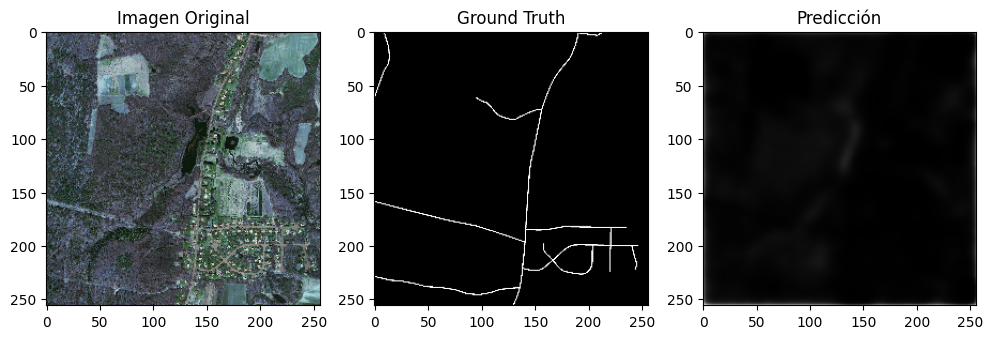

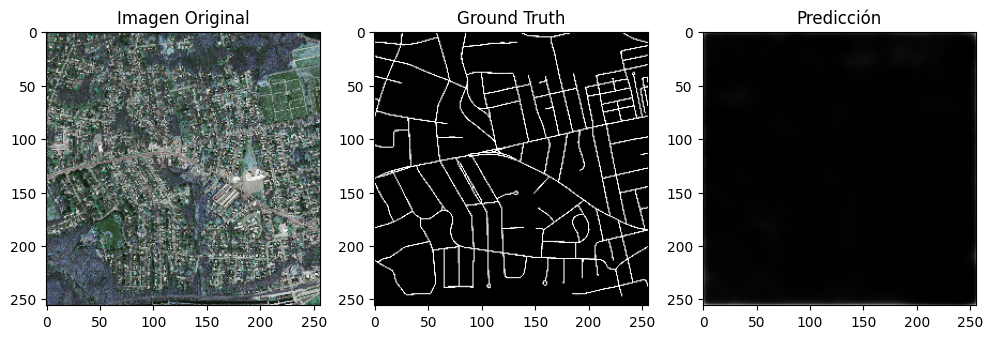

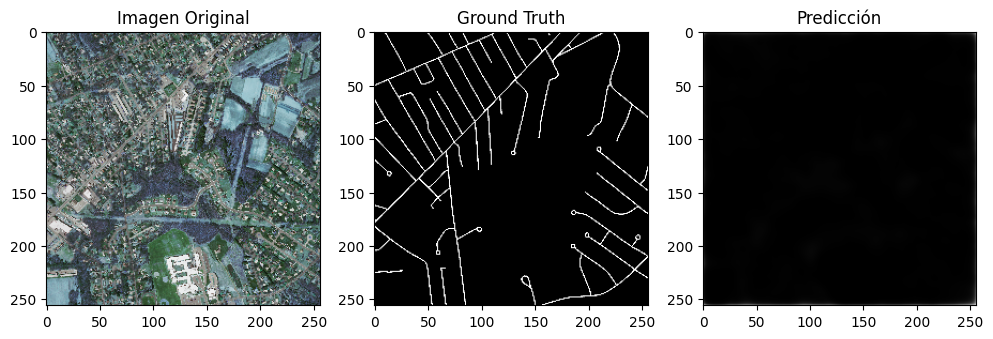

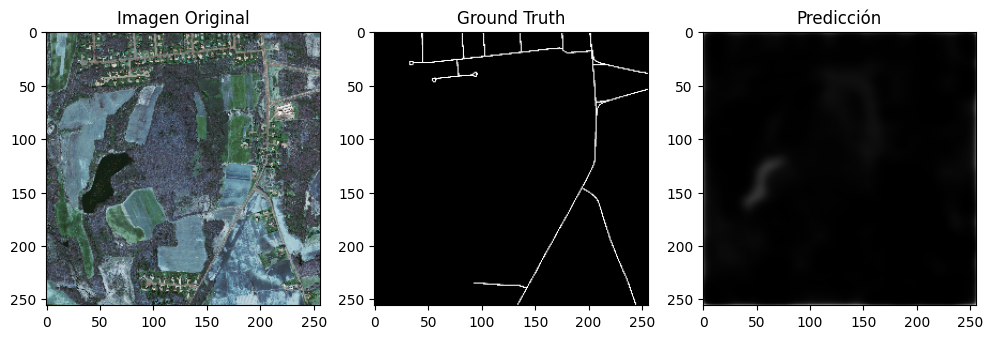

In [ ]:
# PARA VER SI FUNCIONA (ES DE CHAT ASI Q NO TE FIES)
def calculate_iou(y_true, y_pred, threshold=0.5):
    """Calcula el Intersection over Union (IoU)."""
    y_pred = (y_pred > threshold).astype(int)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred) - intersection
    return intersection / union

# Evaluar en datos de prueba
y_pred = model.predict(X_test)  # Realizar predicciones sobre el conjunto de prueba
iou_scores = [calculate_iou(y_true, y_pred_i) for y_true, y_pred_i in zip(y_test, y_pred)]  # Calcular IoU para cada imagen
print(f"Promedio IoU en el conjunto de prueba: {np.mean(iou_scores):.4f}")

# Visualizar resultados
def visualize_results(image, mask_true, mask_pred):
    """Visualiza una imagen con su ground truth y predicción."""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Imagen Original")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask_true.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicción")
    plt.imshow(mask_pred.squeeze(), cmap='gray')

    plt.show()

# Visualiza los primeros resultados de prueba
for i in range(len(X_test)):  # Visualizar todas las imágenes disponibles en el conjunto de prueba
    visualize_results(X_test[i], y_test[i], y_pred[i])

